In [11]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
import optuna
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv
from datetime import datetime


In [12]:
class RewardLoggingCallback(BaseCallback):
    """
    Custom callback to log rewards during training.
    """
    def __init__(self):
        super().__init__()
        self.episode_rewards = []
        self.current_rewards = []

    def _on_step(self) -> bool:
        reward = self.locals["rewards"]
        done = self.locals["dones"]
        self.current_rewards.append(reward)

        if done:
            self.episode_rewards.append(sum(self.current_rewards))
            self.current_rewards = []
        return True


In [13]:
def optimize_ppo(trial):
    """
    Optimize PPO hyperparameters using Optuna.
    """
    # Set up the environment (CartPole-v1)
    env = gym.make("CartPole-v1")  # Remove render_mode

    # Wrap the environment in a DummyVecEnv for compatibility with PPO
    env = DummyVecEnv([lambda: env])

    lr = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    gamma = trial.suggest_float("gamma", 0.90, 0.99)
    n_epochs = trial.suggest_int("n_epochs", 3, 10)
    ent_coef = trial.suggest_float("ent_coef", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_int("batch_size", 32, 512, step=32)
    n_steps = trial.suggest_int("n_steps", 64, 2048, step=64)
    gae_lambda = trial.suggest_float("gae_lambda", 0.8, 0.99)
    clip_range = trial.suggest_float("clip_range", 0.1, 0.3)

    model = PPO(
        "MlpPolicy",
        env,
        learning_rate=lr,
        gamma=gamma,
        n_epochs=n_epochs,
        ent_coef=ent_coef,
        batch_size=batch_size,
        n_steps=n_steps,
        gae_lambda=gae_lambda,
        clip_range=clip_range,
        verbose=0,
    )
    model.learn(total_timesteps=100000)

    # Evaluate the agent's performance
    total_rewards = []
    for _ in range(50):
        state = env.reset()  # No unpacking needed
        total_reward = 0
        done = False
        while not done:
            action, _ = model.predict(state, deterministic=True)
            state, reward, done, info = env.step(action)  # Unpack four values instead of five
            total_reward += reward
        total_rewards.append(total_reward)

    # Return the mean of total rewards as the optimization objective
    return np.mean(total_rewards)


In [14]:
def plot_learning_curve(rewards):
    """
    Plot the learning curve using the logged rewards from training.

    Args:
        rewards (list): List of total rewards per episode.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(rewards)), rewards, label="Episode Rewards")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Learning Curve for CartPole-v1 (SB3)")
    plt.legend()
    plt.grid()
    plt.show()


In [15]:
def train_and_render_cartpole():
    """
    Train a PPO agent with optimized hyperparameters on CartPole-v1.
    """
    # Hyperparameter Optimization
    study = optuna.create_study(direction="maximize")
    study.optimize(optimize_ppo, n_trials=500)
    best_params = study.best_params
    print("Best Hyperparameters:", best_params)

    # Create the environment
    env = gym.make("CartPole-v1")  # No render_mode

    # Train the agent with best hyperparameters
    final_model = PPO(
        "MlpPolicy",
        env,
        learning_rate=best_params["learning_rate"],
        gamma=best_params["gamma"],
        n_epochs=best_params["n_epochs"],
        ent_coef=best_params["ent_coef"],
        batch_size=best_params["batch_size"],
        n_steps=best_params["n_steps"],
        gae_lambda=best_params["gae_lambda"],
        clip_range=best_params["clip_range"],
        verbose=1,
    )
    callback = RewardLoggingCallback()
    final_model.learn(total_timesteps=100000, callback=callback)

    # Plot the learning curve
    plot_learning_curve(callback.episode_rewards)

    # Evaluation loop
    eval_env = gym.make("CartPole-v1")  # No render_mode
    state = eval_env.reset()
    done = False
    state_trajectory = []

    while not done:
        state_trajectory.append(state)  # Record the state
        action, _ = final_model.predict(state, deterministic=True)
        state, reward, done, truncated, _ = eval_env.step(action)
        done = done or truncated

    eval_env.close()

    # Plotting Pole Angles
    pole_angles = [s[2] for s in state_trajectory]  # Adjust index if necessary
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(pole_angles)), pole_angles, label='Pole Angle', color='b')
    plt.axhline(y=0, color='gray', linestyle='--', linewidth=1, label="Vertical Position")
    plt.xlabel('Time Step')
    plt.ylabel('Pole Angle (radians)')
    plt.title('Pole Angle Over Time During Evaluation (SB3)')
    plt.legend()
    plt.grid()
    plt.show()


[I 2024-12-05 20:42:02,989] A new study created in memory with name: no-name-b503b754-ff5f-4217-856d-615e38459355
/Users/xuenbei/miniconda3/lib/python3.12/site-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 416, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1600`, after every 3 untruncated mini-batches, there will be a truncated mini-batch of size 352
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1600 and n_envs=1)
  warnings.warn(
[I 2024-12-05 20:43:25,865] Trial 0 finished with value: 488.9200134277344 and parameters: {'learning_rate': 5.6312626657220695e-05, 'gamma': 0.9071109648228012, 'n_epochs': 8, 'ent_coef': 0.00292065750768925, 'batch_size': 416, 'n_steps': 1600, 'gae_lambda': 0.8331551413225877, 'clip_range': 0.18176286787125723}. Best is trial 0 with value: 488.9200134277344.
/Users/xuenbei/miniconda3/lib/python3.12/site-packages/stable_baselines3/ppo/ppo.py:155: Use

Best Hyperparameters: {'learning_rate': 0.000970358560560209, 'gamma': 0.9526832402345117, 'n_epochs': 6, 'ent_coef': 0.00011338665387871977, 'batch_size': 160, 'n_steps': 1280, 'gae_lambda': 0.9898336145639194, 'clip_range': 0.1222800710806642}
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.3     |
|    ep_rew_mean     | 23.3     |
| time/              |          |
|    fps             | 2573     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 1280     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 24           |
|    ep_rew_mean          | 24           |
| time/                   |              |
|    fps                  | 8            |
|    iterations           | 2            |
|    time_elapsed  

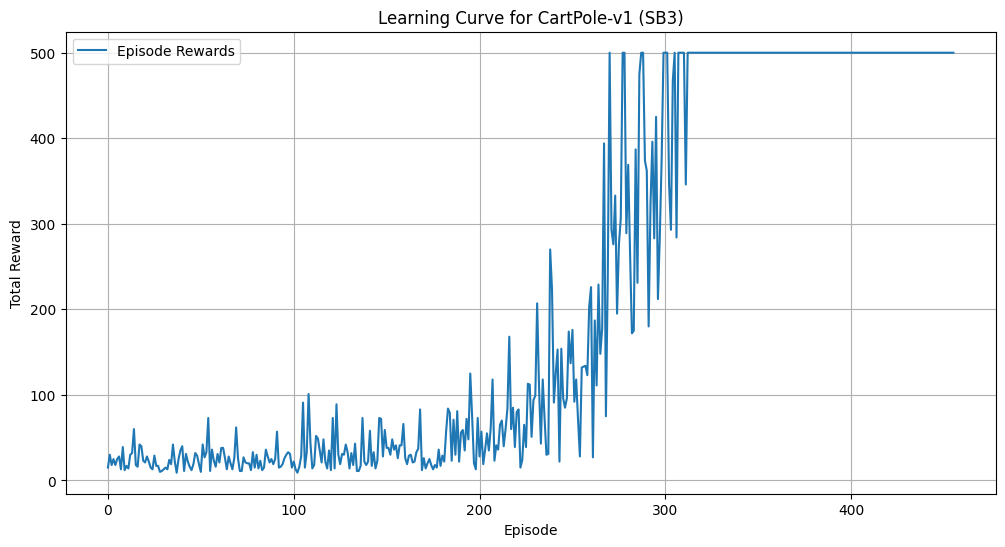

ValueError: You have passed a tuple to the predict() function instead of a Numpy array or a Dict. You are probably mixing Gym API with SB3 VecEnv API: `obs, info = env.reset()` (Gym) vs `obs = vec_env.reset()` (SB3 VecEnv). See related issue https://github.com/DLR-RM/stable-baselines3/issues/1694 and documentation for more information: https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html#vecenv-api-vs-gym-api

In [16]:
if __name__ == "__main__":
    train_and_render_cartpole()
